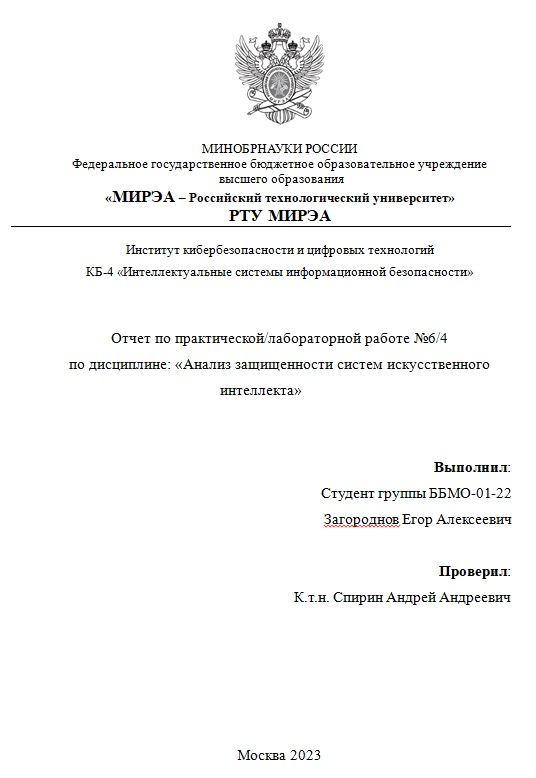


1) Выполним импорт необходимых библиотек.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

2) Загрузим набор данных (MNIST), разобьем данные на подвыборки


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data:",len(test_loader))

Training data: 50000 Validation data: 10000 Test data: 10000


3) Настроим использование графического ускорителя (если возможно)

In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

4) Создадим класс НС на основе фреймворка torch

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

5) Проверим работоспособность созданного класса НС

In [ ]:
model = Net().to(device)

6) Создадим оптимизатор, функцию потерь и трейнер сети

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

7) Определим функцию обучения сети

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

8) Обучим модель

In [ ]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.28326808517104224 Val_Loss: 0.1265355016058539
Epoch: 2 Loss: 0.11512688370708672 Val_Loss: 0.09977492453942101
Epoch: 3 Loss: 0.09174395837025623 Val_Loss: 0.0868764311158393
Epoch: 4 Loss: 0.07797166525497713 Val_Loss: 0.09033281543525218
Epoch: 5 Loss: 0.07014771945959633 Val_Loss: 0.08170175888994963
Epoch: 6 Loss: 0.06368740316237818 Val_Loss: 0.07519124595179415
Epoch: 7 Loss: 0.059813997097934814 Val_Loss: 0.07129589756680675
Epoch: 8 Loss: 0.055227947687258784 Val_Loss: 0.08799879876547438
Epoch: 9 Loss: 0.05471110358008654 Val_Loss: 0.08263800773813335
Epoch: 10 Loss: 0.052813207259373184 Val_Loss: 0.07457457615429666


9) Построим графики потерь при обучении и валидации в
зависимости от эпохи

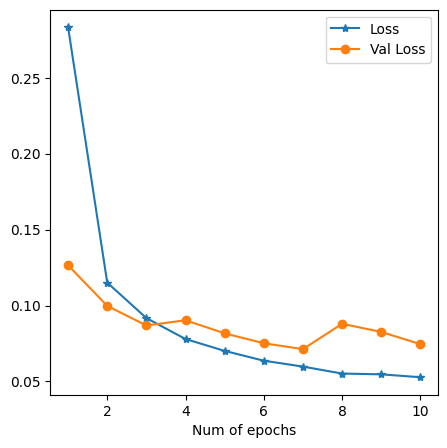

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

10) Создадим функции атак FGSM, I-FGSM, MI-FGSM

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [ ]:
def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [ ]:
def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

11) Создадим функцию проверки

In [ ]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples


12) Построим графики успешности атак (Accuracy/epsilon) и примеры выполненных атак в зависимости от степени возмущения epsilon

Epsilon: 0	Test Accuracy = 9728 / 10000 = 0.9728
Epsilon: 0.007	Test Accuracy = 9686 / 10000 = 0.9686
Epsilon: 0.01	Test Accuracy = 9680 / 10000 = 0.968
Epsilon: 0.02	Test Accuracy = 9639 / 10000 = 0.9639
Epsilon: 0.03	Test Accuracy = 9587 / 10000 = 0.9587
Epsilon: 0.05	Test Accuracy = 9403 / 10000 = 0.9403
Epsilon: 0.1	Test Accuracy = 8761 / 10000 = 0.8761
Epsilon: 0.2	Test Accuracy = 6412 / 10000 = 0.6412
Epsilon: 0.3	Test Accuracy = 4025 / 10000 = 0.4025


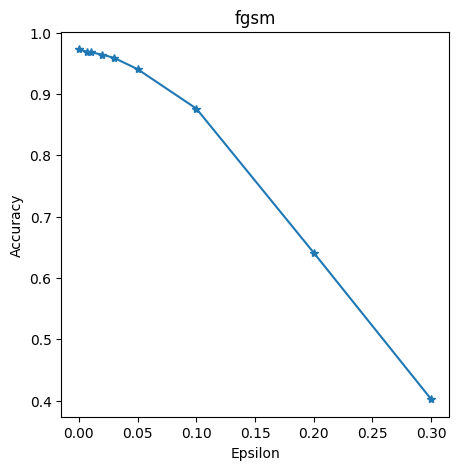

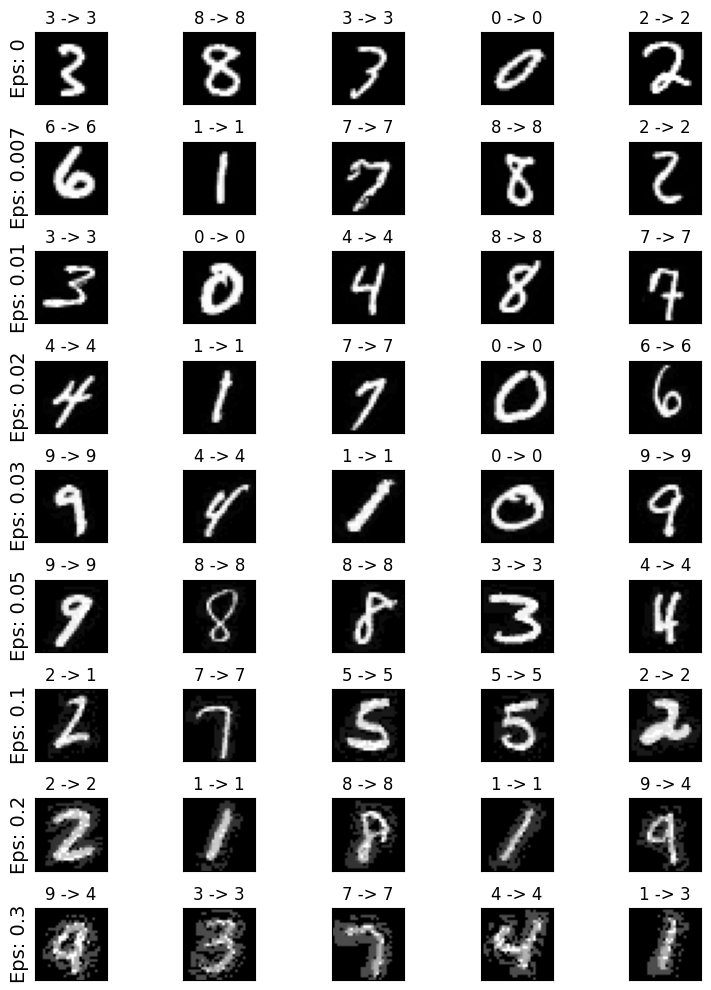

Epsilon: 0	Test Accuracy = 9721 / 10000 = 0.9721
Epsilon: 0.007	Test Accuracy = 9716 / 10000 = 0.9716
Epsilon: 0.01	Test Accuracy = 9673 / 10000 = 0.9673
Epsilon: 0.02	Test Accuracy = 9656 / 10000 = 0.9656
Epsilon: 0.03	Test Accuracy = 9596 / 10000 = 0.9596
Epsilon: 0.05	Test Accuracy = 9452 / 10000 = 0.9452
Epsilon: 0.1	Test Accuracy = 8927 / 10000 = 0.8927
Epsilon: 0.2	Test Accuracy = 6954 / 10000 = 0.6954
Epsilon: 0.3	Test Accuracy = 4646 / 10000 = 0.4646


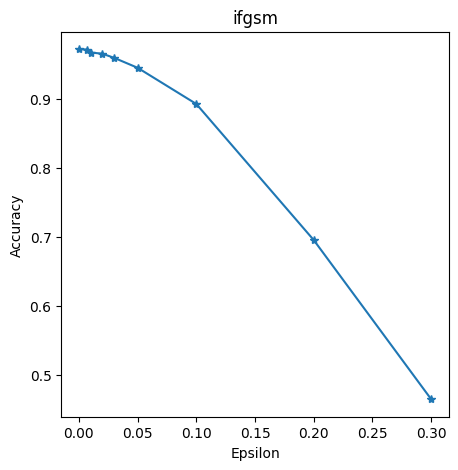

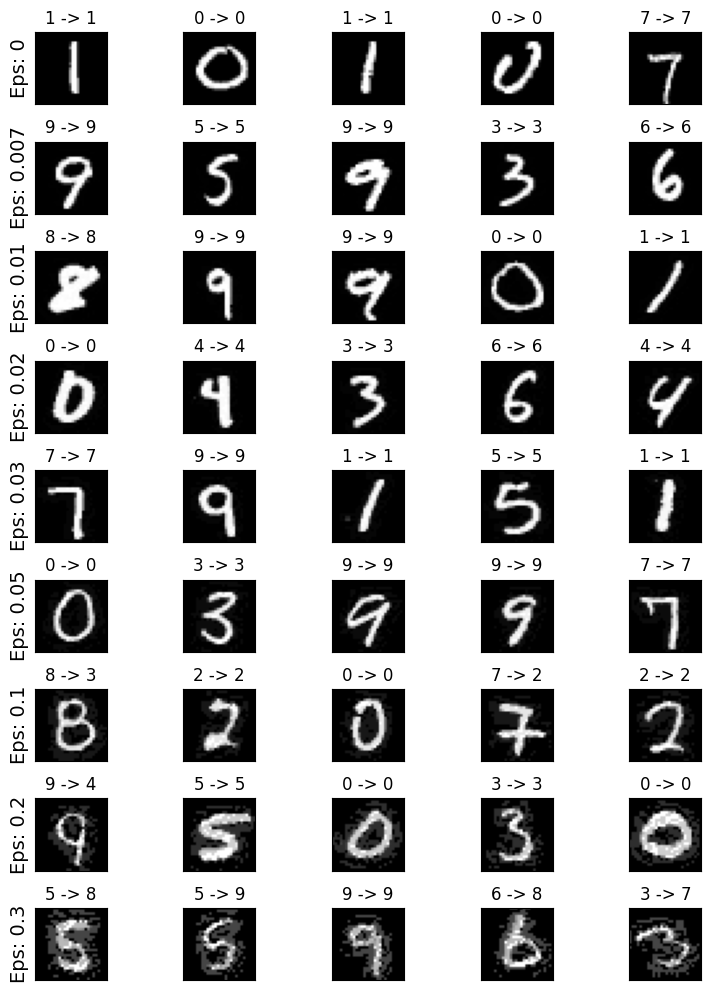

Epsilon: 0	Test Accuracy = 9723 / 10000 = 0.9723
Epsilon: 0.007	Test Accuracy = 9703 / 10000 = 0.9703
Epsilon: 0.01	Test Accuracy = 9693 / 10000 = 0.9693
Epsilon: 0.02	Test Accuracy = 9641 / 10000 = 0.9641
Epsilon: 0.03	Test Accuracy = 9587 / 10000 = 0.9587
Epsilon: 0.05	Test Accuracy = 9461 / 10000 = 0.9461
Epsilon: 0.1	Test Accuracy = 8887 / 10000 = 0.8887
Epsilon: 0.2	Test Accuracy = 6973 / 10000 = 0.6973
Epsilon: 0.3	Test Accuracy = 4647 / 10000 = 0.4647


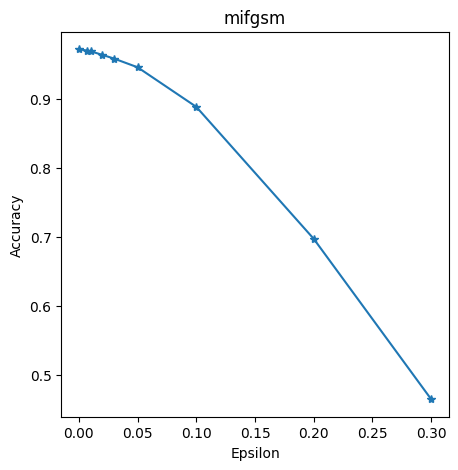

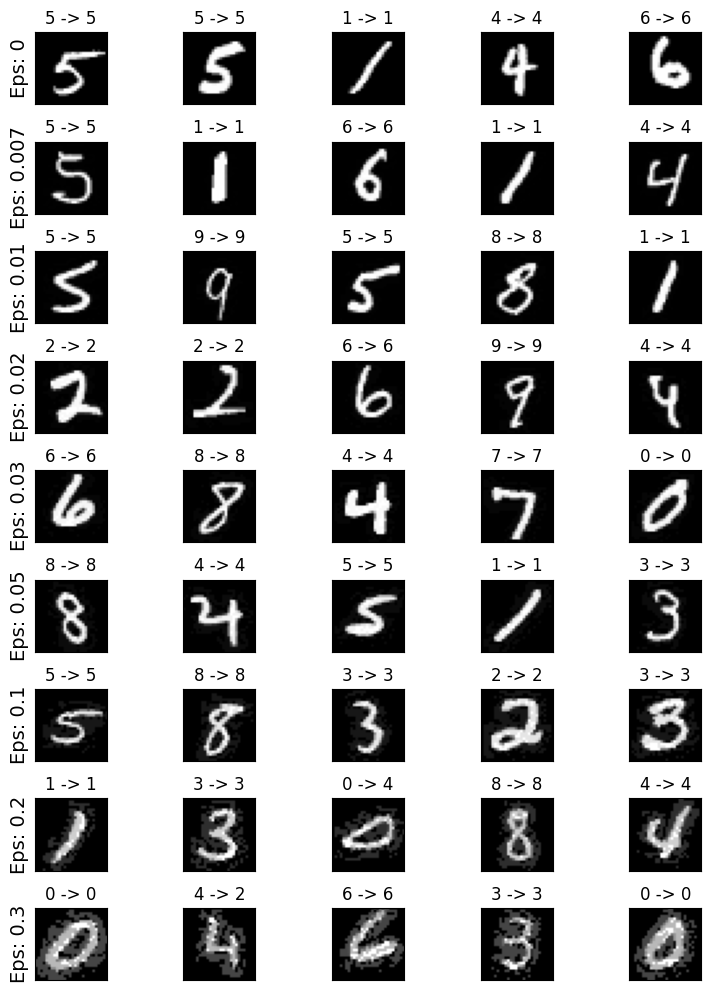

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

13) Создадим 2 класса НС

In [ ]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [ ]:
class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

14) Переопределим функцию обучения и тестирования

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

15) Создадим функцию защиты методом дистилляции

In [ ]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

16) Получаем результаты оценки защищенных сетей

Fitting the model...
Epoch: 1 Loss: 0.5483859603015963 Val_Loss: 4.385302811861038e-05
Epoch: 2 Loss: 0.32460617121258856 Val_Loss: 3.1100654043257235e-06
Epoch: 3 Loss: 0.23777336955400108 Val_Loss: 3.357763446401805e-05
Epoch: 4 Loss: 0.1812173405418598 Val_Loss: 7.011266998597421e-06
Epoch: 5 Loss: 0.150067122153579 Val_Loss: 8.543587891836068e-07
Epoch: 6 Loss: 0.12824328508960078 Val_Loss: 9.128518588840962e-06
Epoch: 7 Loss: 0.1156997473201934 Val_Loss: 0.00015644530914723874
Epoch: 8 Loss: 0.10612900108509152 Val_Loss: 1.3726269360631705e-06
Epoch: 9 Loss: 0.09660122641959273 Val_Loss: 1.670716199441813e-07
Epoch: 10 Loss: 0.09184142990870121 Val_Loss: 1.581453345124828e-06


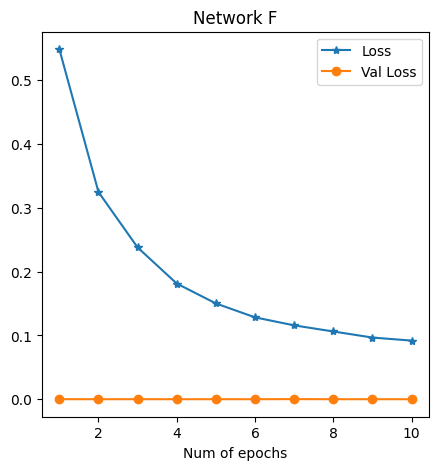

Fitting the model...
Epoch: 1 Loss: 0.6908452295154612 Val_Loss: 0.00010725047383457422
Epoch: 2 Loss: 0.4721156007397357 Val_Loss: 3.8422844978049396e-05
Epoch: 3 Loss: 0.41965729681420266 Val_Loss: 5.346387252211571e-05
Epoch: 4 Loss: 0.3911320006813214 Val_Loss: 5.061847748584114e-06
Epoch: 5 Loss: 0.3582433628921062 Val_Loss: 0.0002144572270102799
Epoch: 6 Loss: 0.3187274682724087 Val_Loss: 4.15364071726799e-05
Epoch: 7 Loss: 0.28688726403368736 Val_Loss: 3.667146642692387e-06
Epoch: 8 Loss: 0.25381293870321575 Val_Loss: 1.1273113047536754e-06
Epoch: 9 Loss: 0.22290950938704665 Val_Loss: 3.7228996865451334e-05
Epoch: 10 Loss: 0.20230280029498893 Val_Loss: 2.545567527413368e-05


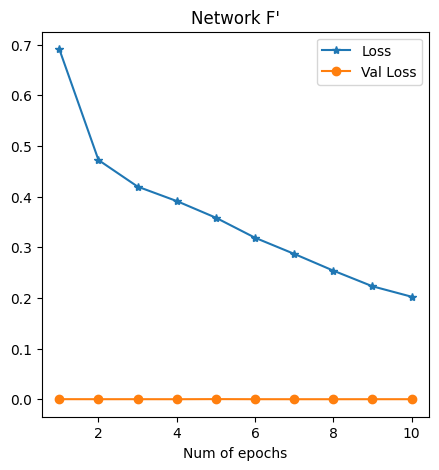

Epsilon: 0	Test Accuracy = 9146 / 10000 = 0.9146
Epsilon: 0.007	Test Accuracy = 9157 / 10000 = 0.9157
Epsilon: 0.01	Test Accuracy = 9148 / 10000 = 0.9148
Epsilon: 0.02	Test Accuracy = 9024 / 10000 = 0.9024
Epsilon: 0.03	Test Accuracy = 8981 / 10000 = 0.8981
Epsilon: 0.05	Test Accuracy = 8702 / 10000 = 0.8702
Epsilon: 0.1	Test Accuracy = 7802 / 10000 = 0.7802
Epsilon: 0.2	Test Accuracy = 4612 / 10000 = 0.4612
Epsilon: 0.3	Test Accuracy = 1756 / 10000 = 0.1756
Epsilon: 0	Test Accuracy = 9142 / 10000 = 0.9142
Epsilon: 0.007	Test Accuracy = 9127 / 10000 = 0.9127
Epsilon: 0.01	Test Accuracy = 9141 / 10000 = 0.9141
Epsilon: 0.02	Test Accuracy = 9025 / 10000 = 0.9025
Epsilon: 0.03	Test Accuracy = 8966 / 10000 = 0.8966
Epsilon: 0.05	Test Accuracy = 8725 / 10000 = 0.8725
Epsilon: 0.1	Test Accuracy = 7845 / 10000 = 0.7845
Epsilon: 0.2	Test Accuracy = 4604 / 10000 = 0.4604
Epsilon: 0.3	Test Accuracy = 1738 / 10000 = 0.1738
Epsilon: 0	Test Accuracy = 9174 / 10000 = 0.9174
Epsilon: 0.007	Test Accur

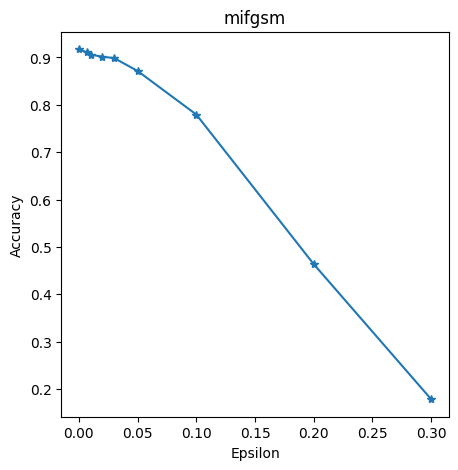

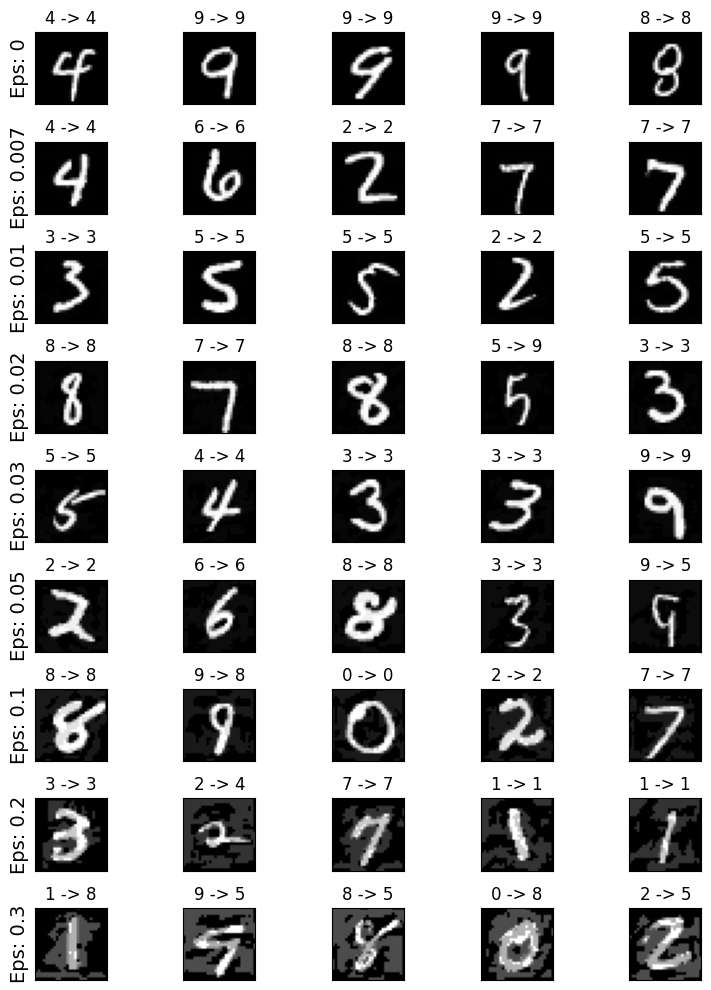

In [ ]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)


**ЗАКЛЮЧЕНИЕ**

В данном исследовании мы успешно разработали модели, загрузили данные, провели их обучение, тестирование и успешно применили метод защитной дистилляции. Защитная дистилляция является эффективным методом для уменьшения сложности нейронных сетей, повышения их обучаемости и ускорения выполнения задач. Однако эффективность этого метода может зависеть от различных факторов, таких как сложность изначальной модели, качество обучения и объем обучающего набора данных.

В данном контексте применение защитной дистилляции существенно улучшило стойкость нашей модели к атакам, повышая точность атакованной модели с уровня 0.14-0.15 до впечатляющих значений в диапазоне 0.90-0.91. Этот результат подчеркивает не только важность защитной дистилляции в контексте повышения безопасности моделей нейронных сетей, но и подчеркивает необходимость учета различных параметров при выборе и применении данного метода в конкретном контексте исследования.